# Advanced usage

This notebook replicates what was done in the *simple_usage* notebooks, but this time with the advanced API. The advanced API is required if we want to use non-standard affinity methods that better preserve global structure.

If you are comfortable with the advanced API, please refer to the *preserving_global_structure* notebook for a guide how obtain better embeddings and preserve more global structure.

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE.affinity import PerplexityBasedNN
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [6]:
%%time
affinities_train = PerplexityBasedNN(
    x_train,
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

CPU times: user 39.6 s, sys: 916 ms, total: 40.6 s
Wall time: 14.2 s


**2. Generate initial coordinates for our embedding**

In [7]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 678 ms, sys: 1.01 s, total: 1.68 s
Wall time: 262 ms


**3. Construct the `TSNEEmbedding` object**

In [8]:
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

**4. Optimize embedding**

1. Early exaggeration phase

In [9]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  5.7892, 50 iterations in 4.2564 sec
Iteration  100, KL divergence  5.2486, 50 iterations in 4.4899 sec
Iteration  150, KL divergence  5.1561, 50 iterations in 4.3038 sec
Iteration  200, KL divergence  5.1202, 50 iterations in 4.5176 sec
Iteration  250, KL divergence  5.1017, 50 iterations in 4.3709 sec
CPU times: user 1min 57s, sys: 48.4 s, total: 2min 45s
Wall time: 22 s


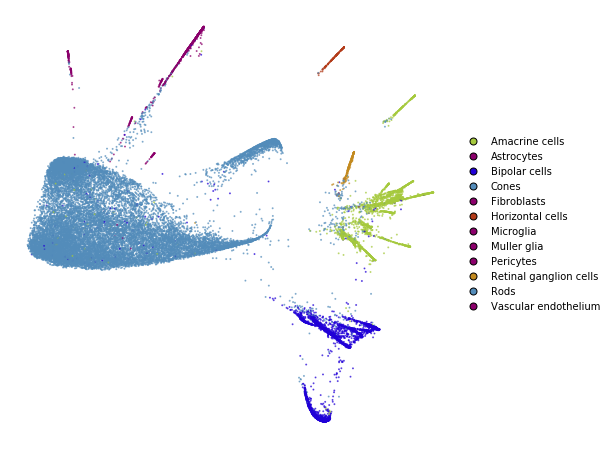

In [10]:
utils.plot(embedding_train_1, y_train, colors=utils.MACOSKO_COLORS)

2. Regular optimization

In [11]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

Iteration   50, KL divergence  3.7967, 50 iterations in 4.5924 sec
Iteration  100, KL divergence  3.4075, 50 iterations in 4.3875 sec
Iteration  150, KL divergence  3.1948, 50 iterations in 4.5558 sec
Iteration  200, KL divergence  3.0539, 50 iterations in 4.7459 sec
Iteration  250, KL divergence  2.9518, 50 iterations in 5.3517 sec
Iteration  300, KL divergence  2.8736, 50 iterations in 5.5623 sec
Iteration  350, KL divergence  2.8124, 50 iterations in 6.2944 sec
Iteration  400, KL divergence  2.7633, 50 iterations in 7.3840 sec
Iteration  450, KL divergence  2.7235, 50 iterations in 6.7175 sec
Iteration  500, KL divergence  2.6910, 50 iterations in 10.3336 sec
Iteration  550, KL divergence  2.6645, 50 iterations in 10.1151 sec
Iteration  600, KL divergence  2.6430, 50 iterations in 8.7347 sec
Iteration  650, KL divergence  2.6254, 50 iterations in 10.0485 sec
Iteration  700, KL divergence  2.6110, 50 iterations in 9.0364 sec
Iteration  750, KL divergence  2.5987, 50 iterations in 11.

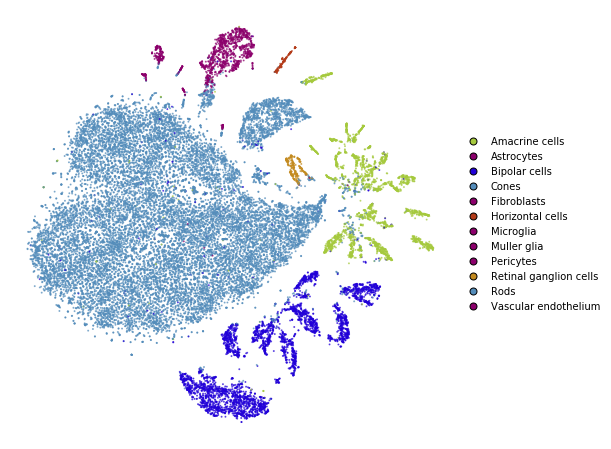

In [12]:
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS)

## Transform

In [13]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

CPU times: user 1.98 s, sys: 0 ns, total: 1.98 s
Wall time: 928 ms


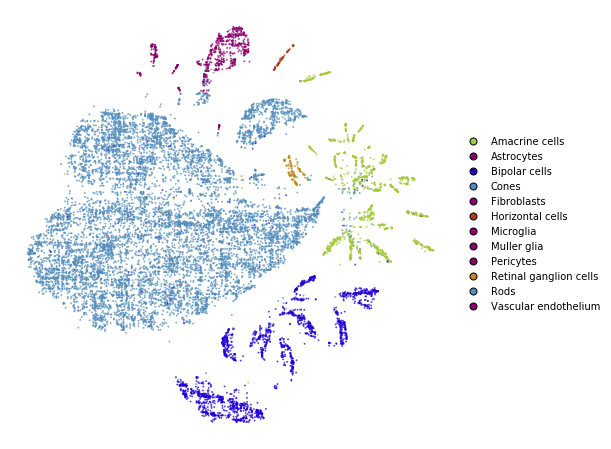

In [14]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

In [15]:
%time embedding_test_1 = embedding_test.optimize(n_iter=250, learning_rate=0.1, momentum=0.8)

Iteration   50, KL divergence  202685.4402, 50 iterations in 15.0963 sec
Iteration  100, KL divergence  202310.1137, 50 iterations in 15.8175 sec
Iteration  150, KL divergence  202257.5092, 50 iterations in 13.0676 sec
Iteration  200, KL divergence  202232.4342, 50 iterations in 16.5648 sec
Iteration  250, KL divergence  202225.3508, 50 iterations in 16.8125 sec
CPU times: user 2min 38s, sys: 1min 29s, total: 4min 7s
Wall time: 1min 17s


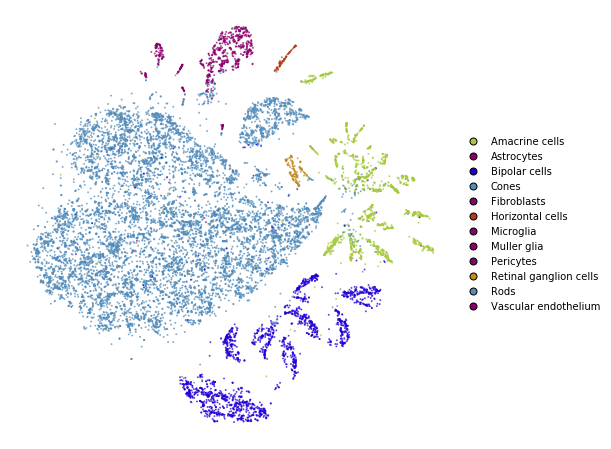

In [16]:
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

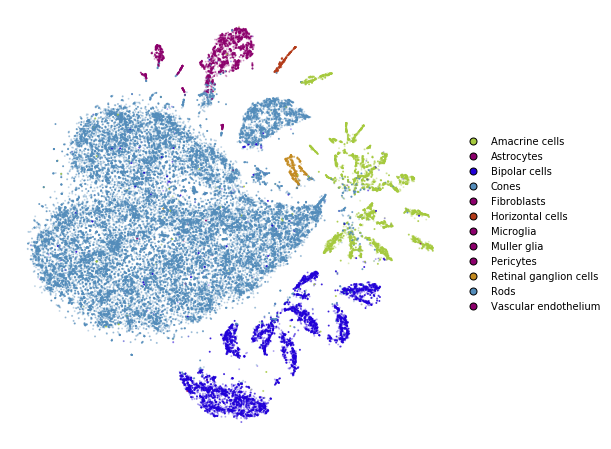

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)